In [4]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

In [6]:
import pandas as pd
df = pd.read_csv('/spam.csv')
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.groupby('Category').describe()

Message                                                               
           count unique                                                top freq
Category                                                                       
ham         4825   4516                             Sorry, I'll call later   30
spam         747    641  Please call our customer service representativ...    4

In [8]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [9]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [10]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [11]:
df_balanced = pd.concat([df_spam,df_ham_downsampled])

In [14]:
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [16]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x:1 if x=='spam' else 0)
df_balanced.sample(10)

,Category,Message,spam
1515,ham,K:)all the best:)congrats...,0
5142,ham,Now that you have started dont stop. Just pray...,0
3111,spam,Good Luck! Draw takes place 28th Feb 06. Good ...,1
2509,ham,Ok...,0
2800,ham,I've told him that i've returned it. That shou...,0
2217,ham,OK i'm waliking ard now... Do u wan me 2 buy a...,0
2680,spam,"New Tones This week include: 1)McFly-All Ab..,...",1
385,spam,Double mins and txts 4 6months FREE Bluetooth ...,1
4451,ham,"Awesome, be there in a minute",0
3897,spam,tells u 2 call 09066358152 to claim £5000 priz...,1


In [39]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(df_balanced['Message'],df_balanced['spam'],stratify=df_balanced['spam'])

In [18]:
X_train.head(5)

872     Its going good...no problem..but still need li...
5237    Someonone you know is trying to contact you vi...
2480    Sppok up ur mob with a Halloween collection of...
1826    Wat makes some people dearer is not just de ha...
1327                      Sorry, was in the bathroom, sup
Name: Message, dtype: object

In [19]:
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [20]:
bert_model = hub.KerasLayer(preprocess_url)

In [21]:
bert_model1 = hub.KerasLayer(encoder_url)

In [22]:
def get_sentence_embedding(sentences):
  preprocess_text = bert_model(sentences)
  return bert_model1(preprocess_text)['pooled_output']


In [30]:
e = get_sentence_embedding([
      "banana",
      "grapes",
      "mango",
      "elon musk"
])

In [31]:
e

<tf.Tensor: shape=(4, 768), dtype=float32, numpy=
array([[-0.7606917 , -0.14219368,  0.49604717, ...,  0.42165378,
        -0.532214  ,  0.80312145],
       [-0.8602321 , -0.21242936,  0.49156952, ...,  0.3979809 ,
        -0.6050628 ,  0.8447165 ],
       [-0.7128862 , -0.15463911,  0.3840172 , ...,  0.35278752,
        -0.5099134 ,  0.734741  ],
       [-0.7504135 , -0.2681262 , -0.26689693, ...,  0.028394  ,
        -0.5938099 ,  0.7974989 ]], dtype=float32)>

In [32]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

In [33]:
cosine_similarity([e[2]],[e[3]])

array([[0.8964417]], dtype=float32)

In [34]:
text_input = tf.keras.layers.Input(shape=(),dtype=tf.string,name="text")
preprocessed_text = bert_model(text_input)
outputs = bert_model1(preprocessed_text)

l = tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)

model = tf.keras.Model(inputs = [text_input],outputs = [l])


In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [36]:
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [37]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
35/35 [==============================] - 366s 10s/step - loss: 0.6327 - accuracy: 0.6580 - precision: 0.6583 - recall: 0.6571
Epoch 2/10
35/35 [==============================] - 352s 10s/step - loss: 0.5143 - accuracy: 0.8045 - precision: 0.8117 - recall: 0.7929
Epoch 3/10
35/35 [==============================] - 351s 10s/step - loss: 0.4485 - accuracy: 0.8491 - precision: 0.8319 - recall: 0.8750
Epoch 4/10
35/35 [==============================] - 351s 10s/step - loss: 0.4092 - accuracy: 0.8696 - precision: 0.8657 - recall: 0.8750
Epoch 5/10
35/35 [==============================] - 351s 10s/step - loss: 0.3732 - accuracy: 0.8705 - precision: 0.8511 - recall: 0.8982
Epoch 6/10
35/35 [==============================] - 350s 10s/step - loss: 0.3540 - accuracy: 0.8830 - precision: 0.8692 - recall: 0.9018
Epoch 7/10
35/35 [==============================] - 351s 10s/step - loss: 0.3231 - accuracy: 0.9009 - precision: 0.8891 - recall: 0.9161
Epoch 8/10
35/35 [=======================

In [41]:
model.evaluate(X_test,y_test)

12/12 [==============================] - 117s 10s/step - loss: 0.2709 - accuracy: 0.9011 - precision: 0.9167 - recall: 0.8824


[0.27092429995536804,
 0.9010695219039917,
 0.9166666865348816,
 0.8823529481887817]

In [46]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [47]:
import numpy as np
y_predicted = np.where(y_predicted>0.5,1,0)
y_predicted

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,

In [50]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test, y_predicted)
cm

array([[172,  15],
       [ 22, 165]])

Text(33.0, 0.5, 'Truth')

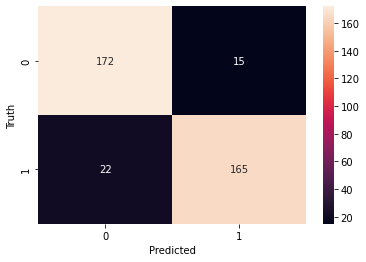

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [52]:
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       187
           1       0.92      0.88      0.90       187

    accuracy                           0.90       374
   macro avg       0.90      0.90      0.90       374
weighted avg       0.90      0.90      0.90       374

